In [1]:
# --- Imports ---
import sys
import os
# Add the project root to the Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk

# Import our custom dataset class from the src directory
from src.data_loader import UterusDataset

# --- Configuration ---
manifest_path = '../data/d2_manifest_t2fs.csv'
image_size = 256

# --- Data Loading and Verification ---
# Instantiate the dataset. The transforms are now handled inside the class.
full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size)

print(f"\nSuccessfully loaded dataset with {len(full_dataset)} slices.")

Loading manifest from ../data/d2_manifest_t2fs.csv and creating slice map...
Slice map created. Found 582 slices containing the uterus.

Successfully loaded dataset with 582 slices.


In [2]:
# --- Step 2.1: Build the 2D U-Net Architecture ---

import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting Path (Encoder)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Expanding Path (Decoder)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        # Final output layer
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1 = self.inc(x)
        s2 = self.down1(s1)
        s3 = self.down2(s2)
        s4 = self.down3(s3)
        s5 = self.down4(s4)

        # Decoder
        x = self.up1(s5)
        # The torch.cat is the skip connection!
        x = torch.cat([x, s4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, s3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, s2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x, s1], dim=1)
        x = self.conv4(x)
        
        logits = self.outc(x)
        return logits

# --- Sanity Check ---
# Let's create a dummy input tensor to test our model's architecture

# Instantiate the model: 1 input channel (grayscale), 1 output channel (uterus mask)
model = UNet(n_channels=1, n_classes=1)

# Create a random tensor with the shape of our preprocessed images
# (batch_size, channels, height, width)
dummy_input = torch.randn(1, 1, image_size, image_size)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output shape
print("--- U-Net Sanity Check ---")
print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")

# The output shape should match the input shape in height and width
assert dummy_input.shape == output.shape, "Output shape does not match input shape!"
print("\nSuccess! The U-Net architecture is correctly implemented.")

--- U-Net Sanity Check ---
Input shape:  torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])

Success! The U-Net architecture is correctly implemented.


## PyTorch info 

In PyTorch, image data is almost always organized in a 4-dimensional tensor with the following structure: (N, C, H, W)

- N (Batch Size): The first 1 is the batch size. Neural networks process images in batches for efficiency. When we tested our model, we sent a "batch" containing just one single image. When we start training, this number will be larger, for example, [16, 1, 256, 256], meaning we are processing 16 images at once.
Analogy: Think of a photo album. N is the number of photos you pull out to look at simultaneously. We just pulled out one.

- C (Channels): The second 1 is the number of channels. This represents the "depth" of the image. A standard color photo (RGB) has 3 channels: one for red, one for green, and one for blue. Its shape would be [N, 3, H, W]. Our MRI scans are grayscale, so they only have 1 channel representing pixel intensity.
Similarly, our output is a single segmentation map where each pixel will represent the probability of being "uterus" or "not uterus". Since it's one map, it's also 1 channel.

- H, W (Height, Width)


Data successfully split:
Training slices: 59
Validation slices: 14

Using device: cpu

--- Starting Baseline Model Training ---


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.93s/it]


Epoch 1/5 -> Train Loss: 0.7935, Val Loss: 0.8280, Val Dice: 0.0674


Validation: 100%|██████████| 1/1 [00:11<00:00, 11.00s/it]


Epoch 2/5 -> Train Loss: 0.7497, Val Loss: 0.8289, Val Dice: 0.0674


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.44s/it]


Epoch 3/5 -> Train Loss: 0.7154, Val Loss: 0.8275, Val Dice: 0.0676


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


Epoch 4/5 -> Train Loss: 0.6883, Val Loss: 0.8157, Val Dice: 0.0979


Validation: 100%|██████████| 1/1 [00:12<00:00, 12.69s/it]


Epoch 5/5 -> Train Loss: 0.6667, Val Loss: 0.7834, Val Dice: 0.1912
--- Finished Training ---


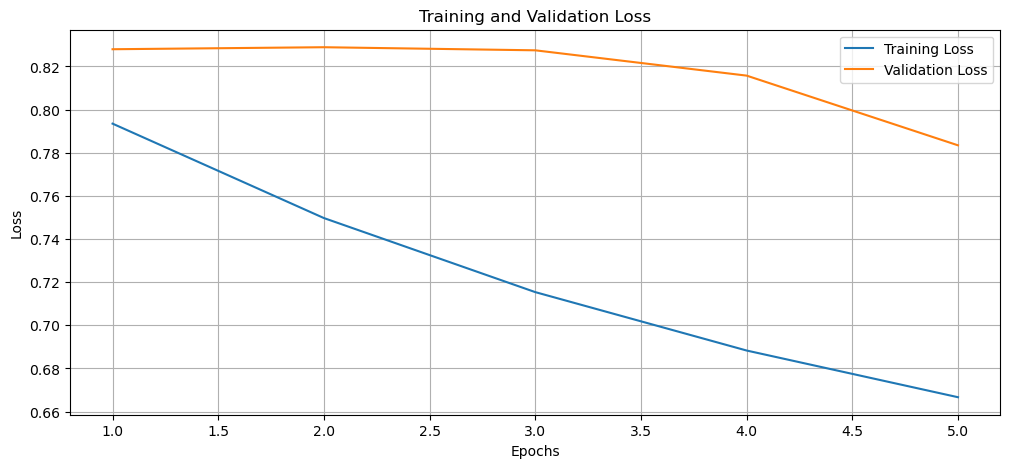

In [3]:
# --- Step 2.2: Implement the Training Loop ---

from torch.utils.data import Subset
from torch.optim import Adam
from tqdm import tqdm # For a nice progress bar

# 1. --- Data Splitting ---
# As per the RAovSeg paper, we must use their defined patient splits for reproducibility.
# Training/validation subjects IDs: D2-000 – D2-007
# Testing subjects IDs: D2-008 – D2-037
# The paper uses patients 0-7 for training/validation. Let's split them further:
# 6 for training, 2 for validation.
train_ids = [f'D2-{i:03d}' for i in range(6)]  # Patients 0 to 5
val_ids = [f'D2-{i:03d}' for i in range(6, 8)] # Patients 6 and 7

# Get the indices of the slices that belong to training and validation patients
train_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.iloc[sm['patient_index']]['patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.iloc[sm['patient_index']]['patient_id'] in val_ids]

# Create PyTorch Subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Data successfully split:")
print(f"Training slices: {len(train_dataset)}")
print(f"Validation slices: {len(val_dataset)}")


# 2. --- Metrics and Loss Function ---

def dice_score(preds, targets, epsilon=1e-6):
    """Calculates the Dice score."""
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

class DiceBCELoss(nn.Module):
    """Combined Dice and Binary Cross-Entropy loss."""
    def __init__(self, weight=0.5, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.weight = weight # The weight for the BCE part of the loss

    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to model output to get probabilities
        inputs = torch.sigmoid(inputs)       
        
        # Flatten label and prediction tensors
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        # Calculate BCE loss
        bce = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')
        
        # Calculate Dice loss
        intersection = (inputs_flat * targets_flat).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)  
        
        # Return a weighted combination of the two losses
        return bce * self.weight + dice_loss * (1 - self.weight)

# 3. --- Training and Validation Functions ---

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    return running_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Convert outputs to probabilities and then to binary predictions for Dice score
            preds = torch.sigmoid(outputs) > 0.5
            dice = dice_score(preds, masks)
            
            running_loss += loss.item() * images.size(0)
            running_dice += dice.item() * images.size(0)
            
    avg_loss = running_loss / len(loader.dataset)
    avg_dice = running_dice / len(loader.dataset)
    return avg_loss, avg_dice

# 4. --- The Main Loop ---

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Initialize model, optimizer, and loss
baseline_model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(baseline_model.parameters(), lr=1e-4)
criterion = DiceBCELoss()

num_epochs = 5 # Start with a small number of epochs
train_loss_history = []
val_loss_history = []
val_dice_history = []

print("\n--- Starting Baseline Model Training ---")

for epoch in range(num_epochs):
    train_loss = train_one_epoch(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(baseline_model, val_loader, criterion, device)
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)
    
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

print("--- Finished Training ---")

# 5. --- Visualization ---

plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Loading dataset and creating slice map...
Slice map created. Found 582 slices containing the uterus.
Data successfully split:
Training slices: 59
Validation slices: 14

Using device: cpu

--- Starting Baseline Model Training ---


Validation: 100%|██████████| 1/1 [00:11<00:00, 11.87s/it]


Epoch 1/5 -> Train Loss: 0.7547, Val Loss: 0.7842, Val Dice: 0.0000


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.90s/it]


Epoch 2/5 -> Train Loss: 0.7115, Val Loss: 0.7728, Val Dice: 0.0000


Validation: 100%|██████████| 1/1 [00:11<00:00, 11.33s/it]


Epoch 3/5 -> Train Loss: 0.6778, Val Loss: 0.7672, Val Dice: 0.0000


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.95s/it]


Epoch 4/5 -> Train Loss: 0.6500, Val Loss: 0.7795, Val Dice: 0.1764


Validation: 100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


Epoch 5/5 -> Train Loss: 0.6241, Val Loss: 0.7535, Val Dice: 0.1517
--- Finished Training ---


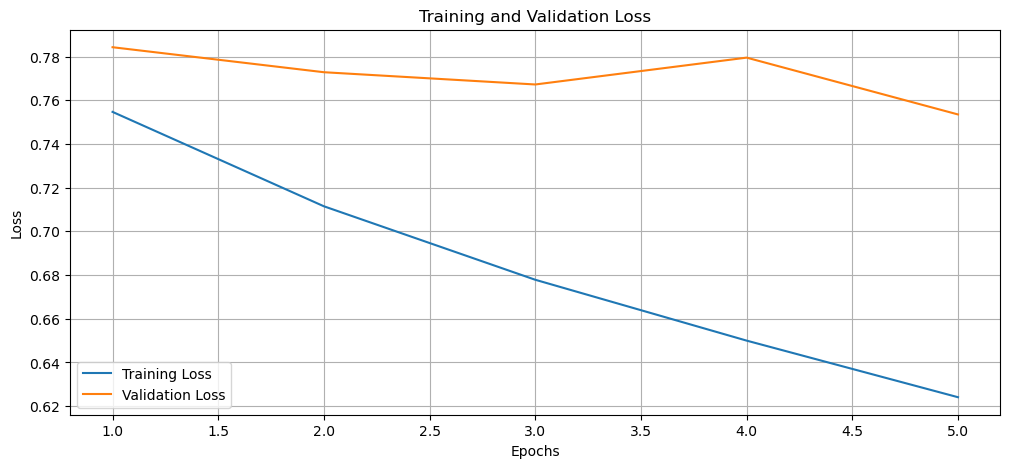

In [4]:
# --- Step 2.1 & 2.2 (Corrected): U-Net, Dataset, and Training Loop ---

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
import torchvision.transforms as T

# --- Corrected UterusDataset Class ---
class UterusDataset(Dataset):
    def __init__(self, manifest_path, image_size=256):
        self.manifest = pd.read_csv(manifest_path)
        self.image_size = image_size
        self.slice_map = []
        
        # Define the separate resize transforms
        self.image_transform = T.Resize((image_size, image_size), interpolation=T.InterpolationMode.BICUBIC, antialias=True)
        self.mask_transform = T.Resize((image_size, image_size), interpolation=T.InterpolationMode.NEAREST, antialias=True)
        
        print("Loading dataset and creating slice map...")
        for patient_index, row in self.manifest.iterrows():
            mask_image = sitk.ReadImage(row['mask_path'])
            num_slices = mask_image.GetSize()[2]
            
            for slice_index in range(num_slices):
                mask_array = sitk.GetArrayFromImage(mask_image)
                if np.sum(mask_array[slice_index, :, :]) > 0:
                    self.slice_map.append({'patient_index': patient_index, 'slice_index': slice_index})
        print(f"Slice map created. Found {len(self.slice_map)} slices containing the uterus.")

    def __len__(self):
        return len(self.slice_map)

    def __getitem__(self, idx):
        slice_info = self.slice_map[idx]
        patient_data = self.manifest.iloc[slice_info['patient_index']]
        
        mri_image = sitk.ReadImage(patient_data['mri_path'], sitk.sitkFloat32)
        mask_image = sitk.ReadImage(patient_data['mask_path'], sitk.sitkUInt8)
        
        mri_slice = sitk.GetArrayFromImage(mri_image)[slice_info['slice_index'], :, :]
        mask_slice = sitk.GetArrayFromImage(mask_image)[slice_info['slice_index'], :, :]
        
        image_tensor = torch.from_numpy(mri_slice).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask_slice).unsqueeze(0).float()
        
        # Apply the correct resize transforms
        image_tensor = self.image_transform(image_tensor)
        mask_tensor = self.mask_transform(mask_tensor)
        
        # Normalize the image tensor to [0, 1]
        min_val, max_val = image_tensor.min(), image_tensor.max()
        if max_val > min_val:
            image_tensor = (image_tensor - min_val) / (max_val - min_val)
            
        return image_tensor, mask_tensor

# --- U-Net Architecture (Unchanged) ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1, self.down2, self.down3, self.down4 = (nn.Sequential(nn.MaxPool2d(2), DoubleConv(c_in, c_out)) for c_in, c_out in [(64, 128), (128, 256), (256, 512), (512, 1024)])
        self.up1, self.up2, self.up3, self.up4 = (nn.ConvTranspose2d(c_in, c_out, kernel_size=2, stride=2) for c_in, c_out in [(1024, 512), (512, 256), (256, 128), (128, 64)])
        self.conv1, self.conv2, self.conv3, self.conv4 = (DoubleConv(c_in, c_out) for c_in, c_out in [(1024, 512), (512, 256), (256, 128), (128, 64)])
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        s1 = self.inc(x); s2 = self.down1(s1); s3 = self.down2(s2); s4 = self.down3(s3); s5 = self.down4(s4)
        x = self.conv1(torch.cat([self.up1(s5), s4], dim=1))
        x = self.conv2(torch.cat([self.up2(x), s3], dim=1))
        x = self.conv3(torch.cat([self.up3(x), s2], dim=1))
        x = self.conv4(torch.cat([self.up4(x), s1], dim=1))
        return self.outc(x)

# --- Training Loop Code (Same as before) ---
# ... [The rest of the code for splitting, loss, metrics, and training loop remains the same] ...
# 1. --- Data Splitting ---
train_ids = [f'D2-{i:03d}' for i in range(6)]; val_ids = [f'D2-{i:03d}' for i in range(6, 8)]
full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size)
train_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.iloc[sm['patient_index']]['patient_id'] in train_ids]
val_indices = [i for i, sm in enumerate(full_dataset.slice_map) if full_dataset.manifest.iloc[sm['patient_index']]['patient_id'] in val_ids]
train_dataset = Subset(full_dataset, train_indices); val_dataset = Subset(full_dataset, val_indices)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
print(f"Data successfully split:\nTraining slices: {len(train_dataset)}\nValidation slices: {len(val_dataset)}")

# 2. --- Metrics and Loss Function ---
def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1); targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2. * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)

class DiceBCELoss(nn.Module):
    def __init__(self, weight=0.5): super(DiceBCELoss, self).__init__(); self.weight = weight
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs); inputs_flat = inputs.view(-1); targets_flat = targets.view(-1)
        bce = F.binary_cross_entropy(inputs_flat, targets_flat, reduction='mean')
        intersection = (inputs_flat * targets_flat).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs_flat.sum() + targets_flat.sum() + smooth)
        return bce * self.weight + dice_loss * (1 - self.weight)

# 3. --- Training and Validation Functions ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train(); running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad(); outputs = model(images); loss = criterion(outputs, masks); loss.backward(); optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def validate(model, loader, criterion, device):
    model.eval(); running_loss = 0.0; running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images); loss = criterion(outputs, masks)
            preds = torch.sigmoid(outputs) > 0.5; dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0); running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)

# 4. --- The Main Loop ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"\nUsing device: {device}")
baseline_model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = Adam(baseline_model.parameters(), lr=1e-4)
criterion = DiceBCELoss()
num_epochs = 5; train_loss_history, val_loss_history, val_dice_history = [], [], []

print("\n--- Starting Baseline Model Training ---")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(baseline_model, val_loader, criterion, device)
    train_loss_history.append(train_loss); val_loss_history.append(val_loss); val_dice_history.append(val_dice)
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
print("--- Finished Training ---")

# 5. --- Visualization ---
plt.figure(figsize=(12, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True); plt.show()

In [5]:
# --- Sanity Check for Attention U-Net ---

# Import the new model from our updated models.py file
from src.models import AttentionUNet

# Instantiate the model
att_model = AttentionUNet(n_channels=1, n_classes=1)

# Create a random dummy input tensor
dummy_input = torch.randn(1, 1, image_size, image_size)

# Pass the dummy input through the model
output = att_model(dummy_input)

# Check the output shape
print("--- Attention U-Net Sanity Check ---")
print(f"Input shape:  {dummy_input.shape}")
print(f"Output shape: {output.shape}")

assert dummy_input.shape == output.shape, "Output shape does not match input shape!"
print("\nSuccess! The Attention U-Net architecture is correctly implemented.")

--- Attention U-Net Sanity Check ---
Input shape:  torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])

Success! The Attention U-Net architecture is correctly implemented.
